In [1]:
import random
import pandas as pd

# Define some synthetic sequences and labels
sequences = [
    "The weather today is sunny and warm.",
    "I just finished reading a great book.",
    "The movie last night was very exciting.",
    "Artificial intelligence is transforming the world.",
    "I love hiking in the mountains.",
    "Cooking new recipes is a lot of fun.",
    "The concert last weekend was amazing.",
    "Python is a versatile programming language.",
    "I enjoy watching sports on weekends.",
    "Machine learning is a fascinating field."
]

# Generate synthetic labels (0 or 1) for binary classification
labels = [random.randint(0, 1) for _ in range(len(sequences))]

# Create a DataFrame
data = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})

# Display the synthetic dataset
data


,sequence,label
0,The weather today is sunny and warm.,1
1,I just finished reading a great book.,0
2,The movie last night was very exciting.,1
3,Artificial intelligence is transforming the wo...,0
4,I love hiking in the mountains.,0
5,Cooking new recipes is a lot of fun.,1
6,The concert last weekend was amazing.,0
7,Python is a versatile programming language.,1
8,I enjoy watching sports on weekends.,0
9,Machine learning is a fascinating field.,0


In [2]:
import numpy as np 
import re 
data_csv = f'./../../toy-data/exp2/data_1.csv'

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=32, replace=False)
df = df.loc[indices].reset_index(drop=True)
df['label'] = [random.randint(0, 1) for _ in range(df.shape[0])]
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Description,label
0,0,3,2,890,18,45,1,1,1,The tenant is a 26-year-old individual who liv...,1
1,4,0,2,1298,0,35,1,1,1,The tenant is a 38-year-old individual with mo...,1
2,0,1,1,1366,0,14,0,1,0,The tenant is a 25-year-old individual with mo...,1
3,4,1,0,650,0,28,1,0,0,The tenant is a 38-year-old individual with mo...,0
4,8,2,1,932,0,43,0,0,0,The tenant is a 52-year-old individual with mo...,0


In [3]:
df[['Description', 'label']]

,Description,label
0,The tenant is a 26-year-old individual who liv...,1
1,The tenant is a 38-year-old individual with mo...,1
2,The tenant is a 25-year-old individual with mo...,1
3,The tenant is a 38-year-old individual with mo...,0
4,The tenant is a 52-year-old individual with mo...,0
5,The tenant is a hardworking individual in thei...,0
6,The tenant is a 35-year-old individual with mo...,0
7,The tenant is a middle-aged individual in thei...,1
8,The tenant is a 38-year-old individual with mo...,0
9,The tenant is a 37-year-old individual with le...,0


In [4]:
var = "Description"
data = df

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader


model_id = "microsoft/phi-3-mini-4k-instruct" #"microsoft/phi-3-mini-4k-instruct" # "meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Meta-Llama-3-8B" # #
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def tokenizer_function(example):
  return tokenizer(example[var], truncation=True, max_length=512)

dataset = Dataset.from_dict(data[[var,'label']])
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns([var])

data_loader = DataLoader(tokenized_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [6]:
import torch
from transformers import Phi3ForSequenceClassification, AdamW
model_id = "microsoft/phi-3-mini-4k-instruct"

# Load the model
model = Phi3ForSequenceClassification.from_pretrained(model_id,
                                                           device_map='auto',
                                                           num_labels=2, 
                                                           torch_dtype=torch.bfloat16,
                                                           attn_implementation="flash_attention_2")

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [8]:
losses = []

model.train()
for epoch in range(20):  # Training for 3 epochs
    for batch in data_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate the loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        losses.append(loss.detach().item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 1.1953125
Epoch 2, Loss: 1.1953125
Epoch 3, Loss: 0.34765625
Epoch 4, Loss: 0.1962890625
Epoch 5, Loss: 0.1416015625
Epoch 6, Loss: 0.07275390625
Epoch 7, Loss: 0.031982421875
Epoch 8, Loss: 0.0169677734375
Epoch 9, Loss: 0.0111083984375
Epoch 10, Loss: 0.0081787109375
Epoch 11, Loss: 0.006561279296875
Epoch 12, Loss: 0.005615234375
Epoch 13, Loss: 0.004974365234375
Epoch 14, Loss: 0.004547119140625
Epoch 15, Loss: 0.00421142578125
Epoch 16, Loss: 0.003936767578125
Epoch 17, Loss: 0.003814697265625
Epoch 18, Loss: 0.003631591796875
Epoch 19, Loss: 0.0034942626953125
Epoch 20, Loss: 0.0033721923828125


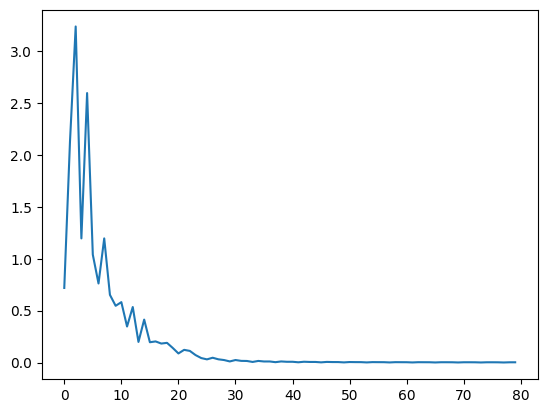

In [9]:
import matplotlib.pyplot as plt 
plt.plot(losses)